# Part 2 of "Map image to satellite image translation using pix2pix (a variant of conditional GAN model)": Train a pix2pix model

1) Link to the Youtube video tutorial: https://www.youtube.com/watch?v=6pUSZgPJ3Yg&list=PLZsOBAyNTZwboR4_xj-n3K6XBTweC4YVD&index=7
2) Link to the stallite-map images dataset: http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
3) Link to other datasets that suitable for pix2pix training: http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/

1) Instruction: 
    1) This is the main script of this tutorial. This script only load the dataset you want, then train the GAN model by importing the functions you defined in the supplementary script. 
    2) Run this script to train the GAN model (pix2pix). Here, we train the pix2pix to receive each satellite image and generated its corresponding map image.
    3) Use the virtual environment called GPUEnv to run this script. This virtual environemnt uses Python 3.7.16 version, Tensorflow 2.6.0 version, Keras 2.6.0 version.
    4) The only difference of this tutorial with the one of Tutorial 7 is:
            1) In this tutorial, a pix2pix is trained to perform image to image translation, by taking a map image as the source image and generate its corresponding fake target image (fake satellite image), while its real target image (involved in the model training) is its corresponding real satellite image.
            2) On contrary, in Tutorial 7, a pix2pix is trained to perform image to image translation, by taking a real image (satellite image) as the source image and generate its corresponding fake target image (fake map image), while its real target image (involved in the model training) is its corresponding real map image.
5) Definition:
    1) Input image (also called Source image) = The image we want to convert to another image
        1) Here, the source image is the map image.
    2) Target image (also called real target image) = The image used to specify the image type we want the generator to generate after training
        1) Here, the real target image is the corresponding real satellite image.
    3) Generated [fake] image (also called fake target image) = The image generated by the generator network
        1) Here, the fake target image is the corresponding generated fake satellite image.
    4) A real sample = an input image concatenated with its corresponding target image
    5) A fake sample = an input image concatenated with its corresponding fake image
    6) The generator network takes an input image to generate a fake image
    7) The discriminator network takes either a real sample or fake sample as the input and provide it a real sample probability score as the output

In [1]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

# Define a function to load all images of a dataset in a directory into memory

1) Here, take note that:
    1) Each map image is an input image (source image)
    2) Each satellite image is a target image (real target image)

In [2]:
# Load all images of a dataset in a directory into memory
def load_images(path, size=(256,512)): # path refers to the directory stores the dataset; size refers to the dimension of each sample (image) in the dataset
	src_list, tar_list = list(), list() # Create 2 empty list, called src_list (the variable that stores all pixels [features] of all source images [map images] in the dataset) & tar_list (the variable that stores all pixels [features] of all their corresponding target images [satellite images] in the dataset).
	# Enumerate filenames in directory, assume all are images. However, take note that when we open an image file (load an image into memory), we get the pixel values (features) of that image.
	for filename in listdir(path): # listdir(path) return a list containing the names (filename) of the entries (files/directories) in the directory called path. In other words, path is the folder that stores images (a list of names). Hence, the variable filename contains a filename (image) at each iteration.
		# Load and resize the image
		pixels = load_img(path + filename, target_size=size) # load_img() loads an image whose directory = (path + filename) in the required size of target_size into PIL format. The loaded image is stored in the variable pixels. This means at each iteration, the variable pixels contains all the pixel values (features) of a loaded image as a PIL image class object in the dimension of target_size.
		# Convert all the pixel values (features) of a loaded image from a PIL image class object into a numpy array (vector)
		pixels = img_to_array(pixels)
		# Split into target image [satellite] and target image [map] (because each loaded image consists a target image [satellite image] on its left part [the pixels (features) describe the target image [satellite image] are the ones at all rows but only from column 1 to column [image_width/2])]and its corresponding source image [map image] on the right part [the pixels (features) describe the corresponding map image are the ones at all rows but only from column [(image_width/2)+1] to last column)]
		sat_img, map_img = pixels[:, :256], pixels[:, 256:] # The pixels (features) having coordinates range of [:, :256] describes the source image [satellite image], so they are stored in the variable sat_img; the pixels (features) having coordinates range of [:, 256:] describes the corresponding target image [map image], so they are stored in the variable map_img
		tar_list.append(sat_img) # Concatenate all the pixels [features] of current target image [satellite image] right after the ones of previous target image [satellite image] in the variable src_list.
		src_list.append(map_img) # Concatenate all the pixels [features] of current source image [map image] right after the ones of previous source image [map image] in the variable tar_list.
	return [asarray(src_list), asarray(tar_list)] # Returns all pixels [features] of all target images [satellite images] in the dataset [src_list] & all pixels [features] of all their corresponding source images [map images] in the dataset [tar_list] as an array.

# Load the dataset images

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


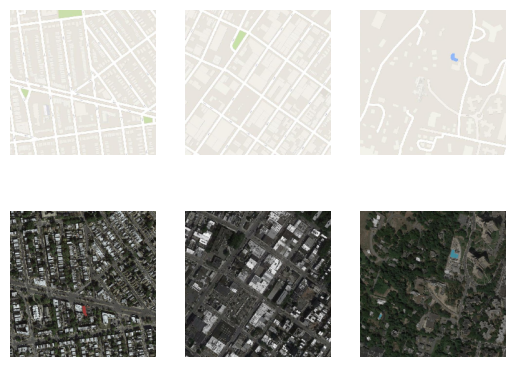

In [3]:
# The relative path to the train set images of the dataset
path = 'data/maps/train/'

# Load the train set images
[src_images, tar_images] = load_images(path) # src_images contains all pixels [features] of all source images [map images] in the train set of the dataset, tar_images contains all pixels [features] of all the corresponding target images [satellite images] in the train set of the dataset
print('Loaded: ', src_images.shape, tar_images.shape) # Show the shapes of src_images and tar_images respectively.

# The codes below are just for the purpose of train set images visualization only
n_samples = 3 # The number of train set images to visualize

# Plot the first 3 source images on the first row of a 2x(n_samples) subplot 
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# Plot the first 3 target images on the second row of a 2x(n_samples) subplot 
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))

# Show that 2x(n_samples) subplot 
pyplot.show()

# Create generator, discriminator, and GAN models respectively

In [4]:
from pix2pix_model_Generate_Realistic_Image import define_discriminator, define_generator, define_gan, train # import the defined functions called (define_discriminator, define_generator, define_gan, train) from the python (.py) file called pix2pix_ConditionalGAN_Model_DigitalSreeni located in the same folder. If you want to use this import defined functions feature, the functions must be defined in a .py file (cannot in a .ipynb file).
# Define input shape based on the loaded dataset
image_shape = src_images.shape[1:] # Since src_images.shape=(1096, 256, 256, 3), src_images.shape[1:]=(256, 256, 3) which also means the shape of each source image

# Define/create the discriminator model using the image_shape
d_model = define_discriminator(image_shape)

# Define/create the generator model using the image_shape
g_model = define_generator(image_shape)

# Define/create the GAN model using the created generator model, created discriminator model, and image_shape
gan_model = define_gan(g_model, d_model, image_shape)

# Define the variable data that stores the pixel values (features) of source images and pixel values (features) of target images respectively (as separate dimension) for training
data = [src_images, tar_images]

c:\Users\weiyo\anaconda3\envs\GPUEnv\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Define a function to scale the pixel values from [0,255] to [-1,1]

In [5]:
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1] # Load the pixel values of source images into the variable X1, load the pixel values of target images into the variable X2
	# Scale all pixel values from [0,255] to [-1,1] (because we use Tanh activation function (provides a value in the range from -1 to 1) at the output layer of the generator network)
	X1 = (X1 - 127.5) / 127.5 # Scale the pixel values of source images
	X2 = (X2 - 127.5) / 127.5 # Scale the pixel values of target images
	return [X1, X2] # Return the scaled pixel values of source images and pixel values of target images respectively

# Train the GAN model (pix2pix)

In [6]:
dataset = preprocess_data(data) # Scale the pixel values of source images and target images from [0,255] to [-1,1], then store them in the variable dataset (as separate dimension) respectively

from datetime import datetime 
start1 = datetime.now() # gets the current local date and time as the GAN model training start date and time

train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1) # Train the GAN model 
    # g_model refers to the built generator network
    # d_model refers to the built discriminator network
    # gan_model refers to the built GAN model (generator network + discriminator network) [Here, it is the pix2pix]
    # dataset refers to the scaled source images and target images of the dataset
    # n_epochs refers to the number of epochs for the GAN model training
    # n_batch refers to the number of sample in each batch
# Reports parameters(performance) for each batch 
# For 10 epochs, we should see 10960th iteration. Because here, we set 1 sample per batch [n_batch = 1], we have total 1096 source images in the variable dataset, so we have total 1096 batches for each epoch. Hence, if we train the GAN model using 10 epochs, we have total 1096*10=10960 iterations).

stop1 = datetime.now() # gets the current local date and time as the GAN model training end date and time
execution_time = stop1-start1 # Calculate the GAN model training duration (Execution time of the model)
print("Execution time is: ", execution_time)

# Reports parameters for each batch (total 1096 batches for each epoch).
# For 10 epochs, we should see 10960 iterations/steps.

>1, d1[0.506] d2[0.609] g[77.030]
>2, d1[0.602] d2[0.635] g[55.501]
>3, d1[0.614] d2[0.437] g[56.957]
>4, d1[0.513] d2[0.759] g[45.205]
>5, d1[0.459] d2[0.492] g[55.474]
>6, d1[0.465] d2[0.326] g[45.466]
>7, d1[0.417] d2[0.375] g[44.960]
>8, d1[0.421] d2[0.328] g[42.593]
>9, d1[0.456] d2[0.321] g[42.934]
>10, d1[0.354] d2[0.386] g[44.914]
>11, d1[0.484] d2[0.305] g[36.828]
>12, d1[0.502] d2[0.509] g[41.147]
>13, d1[0.388] d2[0.342] g[33.700]
>14, d1[0.271] d2[0.279] g[49.198]
>15, d1[0.370] d2[0.264] g[34.591]
>16, d1[0.334] d2[0.219] g[32.364]
>17, d1[0.228] d2[0.402] g[35.325]
>18, d1[0.576] d2[0.215] g[23.639]
>19, d1[0.308] d2[0.426] g[29.663]
>20, d1[0.441] d2[0.116] g[35.024]
>21, d1[0.474] d2[0.230] g[25.396]
>22, d1[0.135] d2[0.500] g[27.107]
>23, d1[0.445] d2[0.228] g[18.513]
>24, d1[0.619] d2[1.848] g[16.200]
>25, d1[0.253] d2[0.897] g[20.022]
>26, d1[0.374] d2[0.389] g[34.571]
>27, d1[0.371] d2[0.360] g[25.024]
>28, d1[0.371] d2[0.196] g[29.613]
>29, d1[0.438] d2[0.200] g[22

# Deploy the trained generator network to generate images

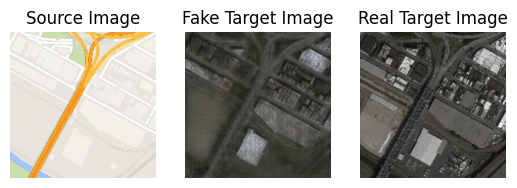

In [7]:
# Test the trained generator model on a few images...

from keras.models import load_model
from numpy.random import randint

# Load the trained generator network of the pix2pix
model = load_model('model_010960.h5')

# Plot a source image and its corresponding generated image (fake target image) and target image (real target image)
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img)) # Stack the pixel values of each image (source image, fake target image, real target image) in sequence vertically (row-wise)
	# Scale the pixel values of each image from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source Image', 'Fake Target Image', 'Real Target Image']
	# Plot the images row by row, as a 1x3 subplot/grid
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show() # Show the 1x3 subplot/grid


# Load the scaled pixel values of source images and pixel values of target images from the variable dataset into the variables X1 and X2 respectively
[X1, X2] = dataset
# Randomly select an index for a source image and a real target image
ix = randint(0, len(X1), 1)
# Using the randomly selected index, load the selected source image and its corresponding real target image into the variables src_image and tar_image respectively
src_image, tar_image = X1[ix], X2[ix]
# Generate the corresponding fake target image using the trained GAN model (pix2pix), then store the generated fake target image into the variable gen_image
gen_image = model.predict(src_image)
# Plot the source image, fake target image, and real target image
plot_images(src_image, gen_image, tar_image)